In [34]:
import numpy as np
import seaborn as sns
import scipy.stats as stat
import pandas as pd
import ast
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
# import ping

In [35]:
def comp_init_movement_dir(traj, proportion=0.1):
    if type(traj) == str:
        traj = np.array(ast.literal_eval(traj)) #Converting from string if string input

    cutoff_dist = proportion*np.sqrt(0.3**2 + 0.3**2) #Determining euclidean distance cutoff

    if len(traj) > 2:
        try:
            origin = traj[np.nonzero(traj)[0][0]] #Taking the first non-zero element as the origin
        except:
            return np.NaN #Returns NaN if no non-zero data points in the trajectory
        
        for cutoff_point in traj[np.nonzero(traj)[0][0]:]:
            euclid_dist = np.sqrt((origin[0] - cutoff_point[0])**2 + (origin[1] - cutoff_point[1])**2) #Euclidean distance cutoff based on proportion
            if euclid_dist > cutoff_dist:
                angle = np.degrees(np.arctan2(cutoff_point[1] - origin[1], cutoff_point[0] - origin[0])) #Tan inverse to compute angle of the difference vector
                return angle
            
    return np.NaN #Returns NaN if trajectory data didn't record.




In [36]:
df_learn = pd.read_csv('df_learn.csv')
df_learn_finalblock = df_learn.loc[df_learn['block'] == 6].reset_index(drop=True)
df_learn_finalblock['init signed errors degrees'] = np.degrees(df_learn_finalblock['init signed errors'])
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == 0.3) & (df_learn_finalblock['target_y'] == 0.3)), 'target_angle'] = 45
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == -0.3) & (df_learn_finalblock['target_y'] == 0.3)), 'target_angle'] = 135
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == -0.3) & (df_learn_finalblock['target_y'] == -0.3)), 'target_angle'] = 225
df_learn_finalblock.loc[((df_learn_finalblock['target_x'] == 0.3) & (df_learn_finalblock['target_y'] == -0.3)), 'target_angle'] = 315



In [37]:
mov_dir = [comp_init_movement_dir(ast.literal_eval(i)) for i in df_learn_finalblock['cursor trajectory']]
df_learn_finalblock['movement_direction'] = mov_dir
# df_learn_finalblock.loc[df_learn_finalblock['movement_direction'] < 0, 'movement_direction'] = 360 + df_learn_finalblock.loc[df_learn_finalblock['movement_direction'] < 0, 'movement_direction']

In [38]:
df_learn_finalblock_targetwise = df_learn_finalblock.groupby(['target_x', 'target_y', 'Rotation', 'Emphasis', 'p_id']).mean().reset_index()
# df_learn_finalblock_targetwise

C:\Users\tejas\AppData\Local\Temp\ipykernel_18128\3159827594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_learn_finalblock_targetwise = df_learn_finalblock.groupby(['target_x', 'target_y', 'Rotation', 'Emphasis', 'p_id']).mean().reset_index()


In [39]:
df_aim = pd.read_csv('aim_reports.csv')
df_aim['aim_report_degrees'] = df_aim['aim report']*4

df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == 0.3)), 'target_angle'] = 45
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == 0.3)), 'target_angle'] = 135
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == -0.3)), 'target_angle'] = 225
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == -0.3)), 'target_angle'] = 315

df_aim["Rotation"] = ["Sudden" if x%2==0 else "Gradual" for x in pd.to_numeric(df_aim["p_id"])]
df_aim["Emphasis"] = ["Accuracy" if (x%4==0 or x%4==1) else "Speed" for x in pd.to_numeric(df_aim["p_id"])]


In [40]:
df_aim_targetwise = df_aim.groupby(['target_x', 'target_y', 'p_id', 'Rotation', 'Emphasis', 'target_angle']).mean().reset_index()


C:\Users\tejas\AppData\Local\Temp\ipykernel_18128\2194957269.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aim_targetwise = df_aim.groupby(['target_x', 'target_y', 'p_id', 'Rotation', 'Emphasis', 'target_angle']).mean().reset_index()


In [41]:
#Collect all relevant columns from aim and final learn block dataframes
df_collective = pd.merge(
    df_aim_targetwise[['p_id', 'target_x', 'target_y', 'Rotation', 'Emphasis', 'target_angle', 'aim_report_degrees']],
    df_learn_finalblock_targetwise[['p_id', 'target_x', 'target_y', 'Rotation', 'target_angle', 'Emphasis', 'movement_direction']],
    on = ['p_id', 'target_x', 'target_y', 'Rotation', 'Emphasis', 'target_angle']
)


#Difference between aim reports and actual movement direction
df_collective['difference'] = (df_collective['aim_report_degrees'] - df_collective['movement_direction'])
#Assigning sign to the difference.
df_collective.loc[df_collective['difference'] > 180, 'difference'] = df_collective.loc[df_collective['difference'] > 180, 'difference'] - 360
df_collective.loc[df_collective['difference'] < -180, 'difference'] = 360 + df_collective.loc[df_collective['difference'] < -180, 'difference']

df_collective_participant = df_collective.groupby(['p_id', 'Rotation', 'Emphasis']).median().reset_index()

Text(0.5, 45, 'Aim Report - Actual Performance')

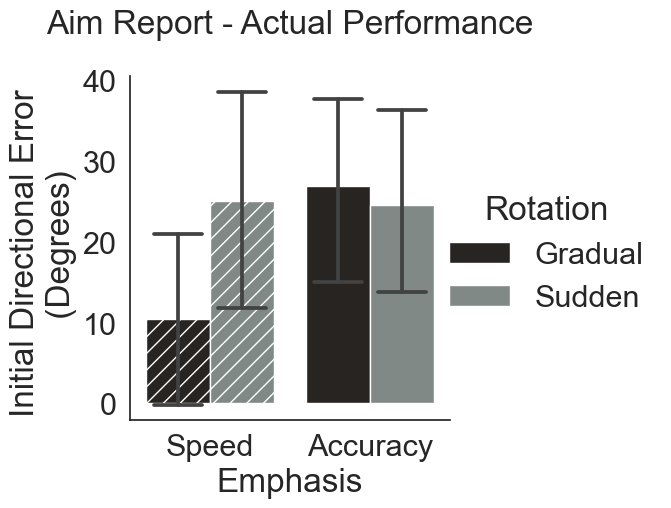

In [60]:
#Plotting
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'difference', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_collective_participant, hue_order=['Gradual', 'Sudden'], order = ['Speed', 'Accuracy'])

hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])

g.set(ylabel='Initial Directional Error \n (Degrees)')
plt.text(0.5, 45, "Aim Report - Actual Performance", ha='center', va='bottom')


In [61]:
#ANOVA
model = ols(
    'difference ~ C(Rotation) * C(Emphasis)', data=df_collective_participant).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Rotation),584.065111,1.0,0.973829,0.327826
C(Emphasis),983.795402,1.0,1.640311,0.205381
C(Rotation):C(Emphasis),1110.666052,1.0,1.851847,0.178833
Residual,34786.157526,58.0,NaN,NaN


In [47]:
#Computing swipe angle from aim data. 
swipe_angle = [comp_init_movement_dir(np.array([ast.literal_eval(df_aim['aim_swipe_mouse.x'][trial]), ast.literal_eval(df_aim['aim_swipe_mouse.y'][trial])]).T) for trial in range(len(df_aim))] 
df_aim['swipe_angle'] = swipe_angle

In [48]:
#Uncomment to plot and test the swipe angles

# trial = 35
# print(df_aim.iloc[trial])
# traj = np.array([ast.literal_eval(df_aim['aim_swipe_mouse.x'][trial]), ast.literal_eval(df_aim['aim_swipe_mouse.y'][trial])]).T
# origin = traj[np.nonzero(traj)[0][0]]
# # origin = np.array([0, 0])
# cutoff_dist = np.sqrt(0.3**2 + 0.3**2)
# for cutoff_point in traj[np.nonzero(traj)[0][0]:]:
#     euclid_dist = np.sqrt((origin[0] - cutoff_point[0])**2 + (origin[1] - cutoff_point[1])**2)
#     if euclid_dist > cutoff_dist:
#         break
# print('cutoff point', cutoff_point)
# print('origin', origin)
# plt.plot([origin[0], cutoff_point[0]], [origin[1], cutoff_point[1]])
# plt.plot([1, -1], [0, 0])
# plt.xlim((-1, 1))
# plt.ylim((-1, 1))
# # plt.scatter(ast.literal_eval(df_aim['aim_swipe_mouse.x'][trial]), ast.literal_eval(df_aim['aim_swipe_mouse.y'][trial]))
# # plt.plot(ast.literal_eval(df_aim['aim_swipe_mouse.x'][trial]), ast.literal_eval(df_aim['aim_swipe_mouse.y'][trial]))
# swipe_angle[trial]

In [49]:
#Difference between reported angles and swipe angles. 
#Participants were asked to swipe to the number the reported.
df_aim['difference'] = df_aim['aim_report_degrees'] - df_aim['swipe_angle']
#Handling signs in the difference
df_aim.loc[df_aim['difference'] > 180, 'difference'] = df_aim.loc[df_aim['difference'] > 180, 'difference'] - 360
df_aim.loc[df_aim['difference'] < -180, 'difference'] = 360 + df_aim.loc[df_aim['difference'] < -180, 'difference']


Text(0.5, 40, 'Aim Report - Swipe Angle')

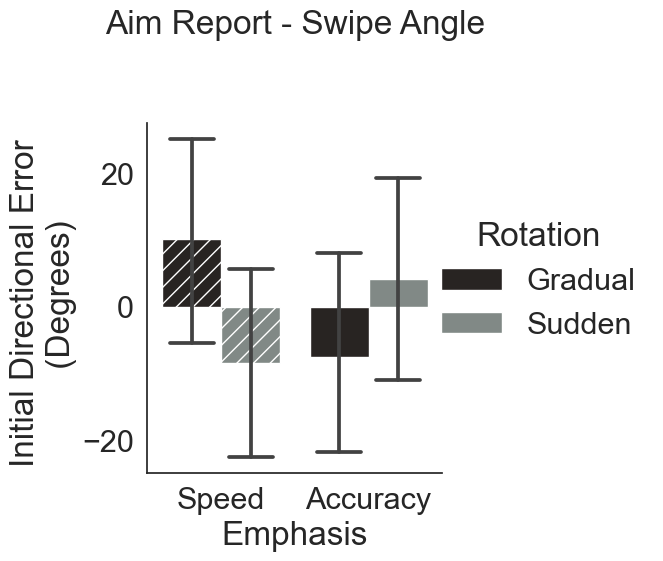

In [50]:
#Plotting
g = sns.catplot(y = 'difference', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim, hue_order=['Gradual', 'Sudden'], order = ['Speed', 'Accuracy'])

hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])

g.set(ylabel='Initial Directional Error \n (Degrees)')
plt.text(0.5, 40, "Aim Report - Swipe Angle", ha='center', va='bottom')


In [52]:
#ANOVA
model = ols(
    'difference ~ C(Rotation) * C(Emphasis)', data=df_aim).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Rotation),1.926225e+03,1.0,0.187889,0.664813
C(Emphasis),5.222357e+02,1.0,0.050940,0.821501
C(Rotation):C(Emphasis),4.026839e+04,1.0,3.927891,0.047882
Residual,7.176338e+06,700.0,NaN,NaN


In [58]:
df_aim_participant = df_aim.groupby(['p_id', 'Rotation', 'Emphasis']).median().reset_index()

C:\Users\tejas\AppData\Local\Temp\ipykernel_18128\119241126.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aim_participant = df_aim.groupby(['p_id', 'Rotation', 'Emphasis']).median().reset_index()


In [59]:
model = ols(
    'difference ~ C(Rotation) * C(Emphasis)', data=df_aim_participant).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Rotation),590.344275,1.0,0.240927,0.625390
C(Emphasis),36.864554,1.0,0.015045,0.902802
C(Rotation):C(Emphasis),11077.202765,1.0,4.520738,0.037754
Residual,142117.894403,58.0,NaN,NaN
